In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyspark

     |████████████████████████████████| 212.3MB 71kB/s 
     |████████████████████████████████| 204kB 47.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=cf582e273b956af8fd43ac39d7ae274b8ced960f78b901cce59431cc07ba58da
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [ ]:
spark = SparkSession.builder.appName("ML-project").getOrCreate()

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Covid Dataset.csv to Covid Dataset.csv
User uploaded file "Covid Dataset.csv" with length 405339 bytes


In [ ]:
#df = spark.read.csv("/content/drive/MyDrive/ML/Project/Dataset/Covid Dataset.csv", header=True)
df = spark.read.csv(fn, header = True)
df.show(n=5)

+-----------------+-----+---------+-----------+------------+------+--------------------+--------+-------------+--------+-------------+--------+-----------------+-------------+--------------------------+------------------------+-----------------------------+---------------------------------------+-------------+------------------------+--------+
|Breathing Problem|Fever|Dry Cough|Sore throat|Running Nose|Asthma|Chronic Lung Disease|Headache|Heart Disease|Diabetes|Hyper Tension|Fatigue |Gastrointestinal |Abroad travel|Contact with COVID Patient|Attended Large Gathering|Visited Public Exposed Places|Family working in Public Exposed Places|Wearing Masks|Sanitization from Market|COVID-19|
+-----------------+-----+---------+-----------+------------+------+--------------------+--------+-------------+--------+-------------+--------+-----------------+-------------+--------------------------+------------------------+-----------------------------+---------------------------------------+-----------

# Preprocessing

In [ ]:
# Counting null values in every columns

from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(column), column)).alias(column) for column in df.columns]).show()

+-----------------+-----+---------+-----------+------------+------+--------------------+--------+-------------+--------+-------------+--------+-----------------+-------------+--------------------------+------------------------+-----------------------------+---------------------------------------+-------------+------------------------+--------+
|Breathing Problem|Fever|Dry Cough|Sore throat|Running Nose|Asthma|Chronic Lung Disease|Headache|Heart Disease|Diabetes|Hyper Tension|Fatigue |Gastrointestinal |Abroad travel|Contact with COVID Patient|Attended Large Gathering|Visited Public Exposed Places|Family working in Public Exposed Places|Wearing Masks|Sanitization from Market|COVID-19|
+-----------------+-----+---------+-----------+------------+------+--------------------+--------+-------------+--------+-------------+--------+-----------------+-------------+--------------------------+------------------------+-----------------------------+---------------------------------------+-----------

In [ ]:
input_columns = ["Breathing Problem", "Fever", "Dry Cough", "Sore throat", "Running Nose", "Asthma", "Chronic Lung Disease", "Headache", "Heart Disease", "Diabetes", "Hyper Tension", "Fatigue ", "Gastrointestinal ", "Abroad travel", "Contact with COVID Patient", "Attended Large Gathering", "Visited Public Exposed Places", "Family working in Public Exposed Places", "Wearing Masks", "Sanitization from Market", "COVID-19"]
output_index_columns = ["Breathing Problem_index", "Fever_index", "Dry Cough_index", "Sore throat_index", "Running Nose_index", "Asthma_index", "Chronic Lung Disease_index", "Headache_index", "Heart Disease_index","Diabetes_index", "Hyper Tension_index", "Fatigue_index", "Gastrointestinal_index", "Abroad travel_index", "Contact with COVID Patient_index", "Attended Large Gathering_index","Visited Public Exposed Places_index", "Family working in Public Exposed Places_index", "Wearing Masks_index", "Sanitization from Market_index", "COVID-19_index"]
df = StringIndexer(
    inputCols = input_columns,
    outputCols = output_index_columns,
    handleInvalid='keep'
    ).fit(df).transform(df)

In [ ]:
df.show(n=5)

+-----------------+-----+---------+-----------+------------+------+--------------------+--------+-------------+--------+-------------+--------+-----------------+-------------+--------------------------+------------------------+-----------------------------+---------------------------------------+-------------+------------------------+--------+------------------+--------------+-----------+--------------+--------------------------------+---------------------------------------------+-------------+----------------------+-------------------+-----------------------+------------+-----------------+--------------------------+--------------+-----------------------------------+-------------------+-------------------+-------------------+------------------------------+---------------+------------------------------+
|Breathing Problem|Fever|Dry Cough|Sore throat|Running Nose|Asthma|Chronic Lung Disease|Headache|Heart Disease|Diabetes|Hyper Tension|Fatigue |Gastrointestinal |Abroad travel|Contact wit

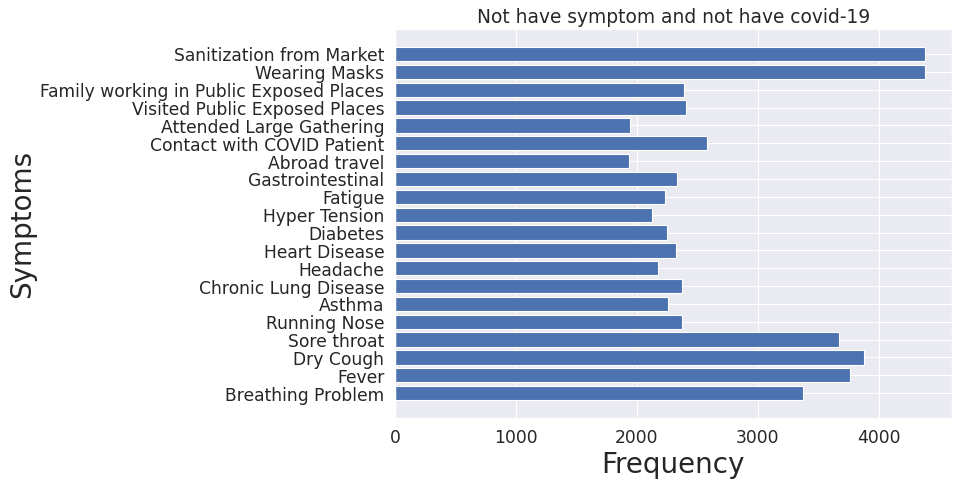

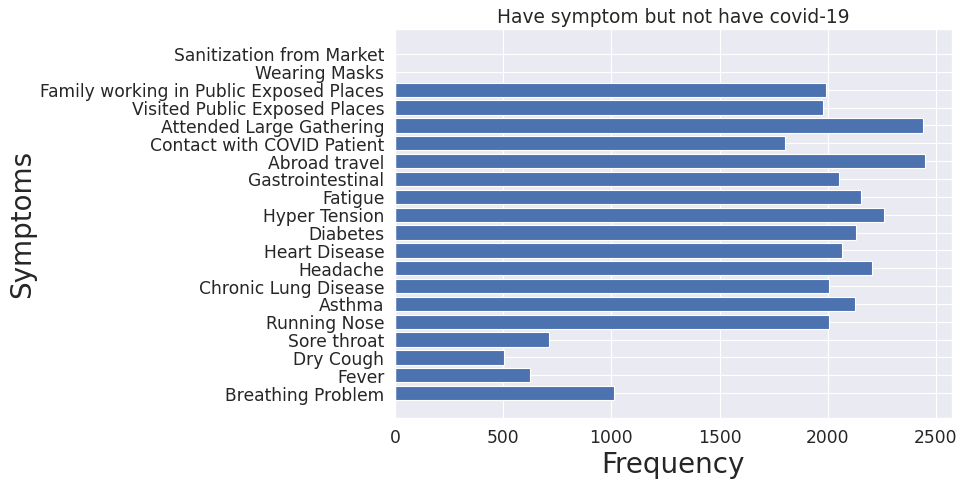

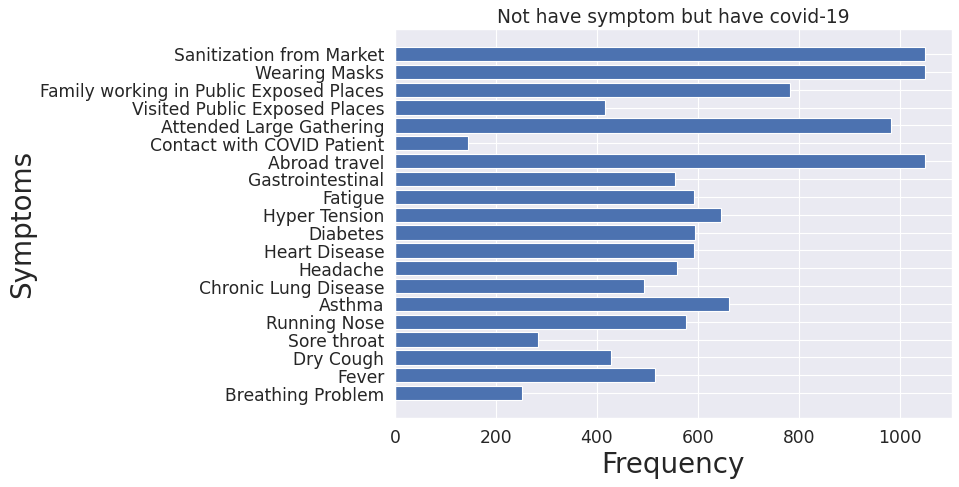

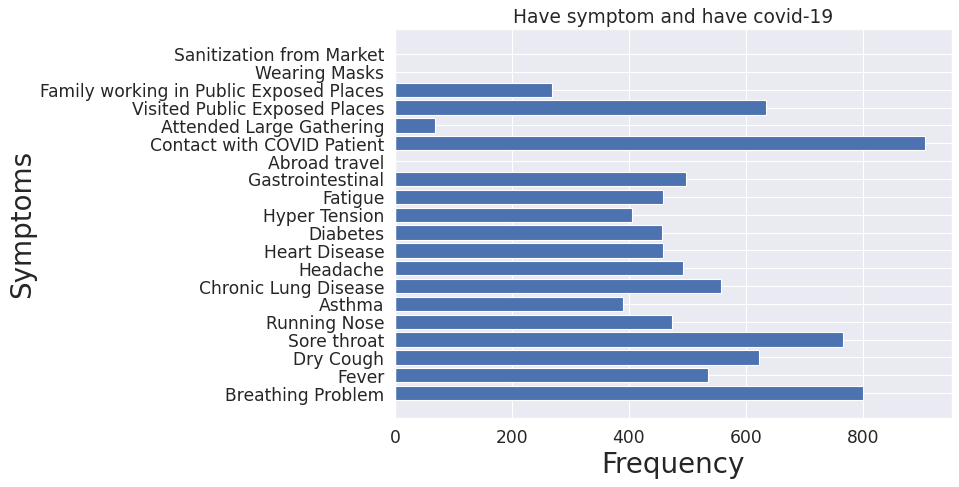

In [ ]:
from matplotlib.pyplot import figure

column_names = output_index_columns
# print(column_names)


def plotGraph(x: dict, title):
  symptoms = list(x.keys())
  freq = list(x.values())
  # print(symptoms, freq)
  figure(figsize=(8, 6), dpi=80)
  plt.barh(symptoms, freq)
  plt.xlabel('Frequency', fontsize = 25)
  plt.ylabel('Symptoms', fontsize = 25)
  plt.title(title)
  plt.show()

def getCount(has_symptoms, has_covid, title):
  x = {}
  for column in column_names:
    if(column != 'COVID-19_index'):
      x[column[:-6]] = df.filter((df[column] == has_symptoms) & (df['COVID-19_index'] == has_covid)).count()
  plotGraph(x, title)


getCount(0,0,'Not have symptom and not have covid-19')
getCount(1,0,'Have symptom but not have covid-19')
getCount(0,1,'Not have symptom but have covid-19')
getCount(1,1,'Have symptom and have covid-19')

# print(x)

In [ ]:
from pyspark.ml.feature import OneHotEncoder
df = df.drop("Breathing Problem", "Fever", "Dry Cough", "Sore throat", "Running Nose", "Asthma", "Chronic Lung Disease", "Headache", "Heart Disease", "Diabetes", "Hyper Tension", "Fatigue ", "Gastrointestinal ", "Abroad travel", "Contact with COVID Patient", "Attended Large Gathering", "Visited Public Exposed Places", "Family working in Public Exposed Places", "Wearing Masks", "Sanitization from Market", "COVID-19")

df = OneHotEncoder(inputCols=["Breathing Problem_index", "Fever_index", "Dry Cough_index", "Sore throat_index", "Running Nose_index", "Asthma_index", "Chronic Lung Disease_index", "Headache_index", "Heart Disease_index","Diabetes_index", "Hyper Tension_index", "Fatigue_index", "Gastrointestinal_index", "Abroad travel_index", "Contact with COVID Patient_index", "Attended Large Gathering_index","Visited Public Exposed Places_index", "Family working in Public Exposed Places_index", "Wearing Masks_index", "Sanitization from Market_index"],
                    outputCols=["Breathing Problem_enc", "Fever_enc", "Dry Cough_enc", "Sore throat_enc", "Running Nose_enc", "Asthma_enc", "Chronic Lung Disease_enc", "Headache_enc", "Heart Disease_enc","Diabetes_enc", "Hyper Tension_enc", "Fatigue_enc", "Gastrointestinal_enc", "Abroad travel_enc", "Contact with COVID Patient_enc", "Attended Large Gathering_enc","Visited Public Exposed Places_enc", "Family working in Public Exposed Places_enc", "Wearing Masks_enc", "Sanitization from Market_enc"], dropLast=True).fit(df).transform(df)

df.show(n=5)

+------------------+--------------+-----------+--------------+--------------------------------+---------------------------------------------+-------------+----------------------+-------------------+-----------------------+------------+-----------------+--------------------------+--------------+-----------------------------------+-------------------+-------------------+-------------------+------------------------------+---------------+------------------------------+----------------------------+-----------------+-------------+-------------+-------------------------------------------+-------------+-----------------+---------------+------------------------+----------------------------+----------------+--------------------+---------------------------------+------------------------------+-----------------+---------------------+-------------+-----------------+-------------+-------------+
|Running Nose_index|Headache_index|Fever_index|COVID-19_index|Contact with COVID Patient_index|Family work

In [ ]:
from pyspark.ml.feature import VectorAssembler

df = VectorAssembler(
    inputCols=["Breathing Problem_enc", "Fever_enc", "Dry Cough_enc", "Sore throat_enc", "Running Nose_enc", "Asthma_enc", "Chronic Lung Disease_enc", "Headache_enc", "Heart Disease_enc","Diabetes_enc", "Hyper Tension_enc", "Fatigue_enc", "Gastrointestinal_enc", "Abroad travel_enc", "Contact with COVID Patient_enc", "Attended Large Gathering_enc","Visited Public Exposed Places_enc", "Family working in Public Exposed Places_enc", "Wearing Masks_enc", "Sanitization from Market_enc"],
    outputCol="encodeFeatures").transform(df)

df.show(n=5)

+------------------+--------------+-----------+--------------+--------------------------------+---------------------------------------------+-------------+----------------------+-------------------+-----------------------+------------+-----------------+--------------------------+--------------+-----------------------------------+-------------------+-------------------+-------------------+------------------------------+---------------+------------------------------+----------------------------+-----------------+-------------+-------------+-------------------------------------------+-------------+-----------------+---------------+------------------------+----------------------------+----------------+--------------------+---------------------------------+------------------------------+-----------------+---------------------+-------------+-----------------+-------------+-------------+--------------------+
|Running Nose_index|Headache_index|Fever_index|COVID-19_index|Contact with COVID Pati

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2000)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3795
Test Dataset Count: 1639


# Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'encodeFeatures', labelCol = 'COVID-19_index', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
predictions = lrModel.transform(test)

In [ ]:
# predictions.select("Breathing Problem_index", "Fever_index", "Dry Cough_index", "Sore throat_index", "Running Nose_index", "Asthma_index", "Chronic Lung Disease_index", "Headache_index", "Heart Disease_index","Diabetes_index", "Hyper Tension_index", "Fatigue_index", "Gastrointestinal_index", "Abroad travel_index", "Contact with COVID Patient_index", "Attended Large Gathering_index","Visited Public Exposed Places_index", "Family working in Public Exposed Places_index", "Wearing Masks_index", "Sanitization from Market_index", "COVID-19_index", 'probability').show(10)
predictions.select('prediction', 'COVID-19_index', 'probability').show()

+----------+--------------+--------------------+
|prediction|COVID-19_index|         probability|
+----------+--------------+--------------------+
|       0.0|           0.0|[0.98873177097099...|
|       0.0|           0.0|[0.98873177097099...|
|       0.0|           0.0|[0.98873177097099...|
|       0.0|           0.0|[0.98873177097099...|
|       0.0|           0.0|[0.99982500990175...|
|       0.0|           0.0|[0.99982500990175...|
|       0.0|           0.0|[0.99982500990175...|
|       0.0|           0.0|[0.99764610382659...|
|       0.0|           0.0|[0.99764610382659...|
|       0.0|           0.0|[0.69015131482312...|
|       0.0|           0.0|[0.69015131482312...|
|       0.0|           0.0|[0.69015131482312...|
|       0.0|           0.0|[0.82729401772578...|
|       0.0|           0.0|[0.82729401772578...|
|       0.0|           0.0|[0.77880360706485...|
|       0.0|           0.0|[0.99995839492747...|
|       0.0|           0.0|[0.99995839492747...|
|       0.0|        

Accuracy: 97.44%
F1 score: 97.43%
Precision: 98.3%
Recall: 98.59%


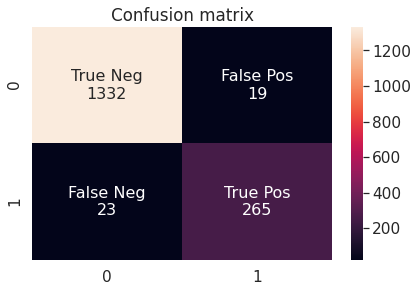

In [ ]:
# Finding Accuracy, F1 score, Precision and Recall of Logistic Regression

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
evaluator.setLabelCol("COVID-19_index")
print('Accuracy: ', round(evaluator.evaluate(predictions) * 100, 2), "%", sep="")

evaluator = MulticlassClassificationEvaluator(metricName='f1')
evaluator.setLabelCol("COVID-19_index")
print('F1 score: ', round(evaluator.evaluate(predictions) * 100, 2), "%", sep="")

evaluator = MulticlassClassificationEvaluator(metricName='precisionByLabel')
evaluator.setLabelCol("COVID-19_index")
print('Precision: ', round(evaluator.evaluate(predictions) * 100, 2), "%", sep="")

evaluator = MulticlassClassificationEvaluator(metricName='recallByLabel')
evaluator.setLabelCol("COVID-19_index")
print('Recall: ', round(evaluator.evaluate(predictions) * 100, 2), "%", sep="")


preds_and_labels = predictions.select(['prediction','COVID-19_index'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
confusion_matrix = metrics.confusionMatrix().toArray()
# print('Confusion matrix: \n', confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_names = ['True Neg','False Pos','False Neg','True Pos']

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=labels, fmt='', annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

# Naive Bayes

In [ ]:
df = pd.read_csv(fn)
df

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Yes
1,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,No,No,No,Yes,Yes,No,No,No,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Yes,Yes,No,No,No,No,No,No,Yes
3,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,No,No,No,Yes,No,Yes,Yes,No,No,No,Yes
4,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,No,No,No,No,Yes
5430,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,No,No,No,No,No,No,No,No,Yes
5431,Yes,Yes,Yes,No,No,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No
5432,Yes,Yes,Yes,No,Yes,No,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No


In [ ]:
print(df.columns)

Index(['Breathing Problem', 'Fever', 'Dry Cough', 'Sore throat',
       'Running Nose', 'Asthma', 'Chronic Lung Disease', 'Headache',
       'Heart Disease', 'Diabetes', 'Hyper Tension', 'Fatigue ',
       'Gastrointestinal ', 'Abroad travel', 'Contact with COVID Patient',
       'Attended Large Gathering', 'Visited Public Exposed Places',
       'Family working in Public Exposed Places', 'Wearing Masks',
       'Sanitization from Market', 'COVID-19'],
      dtype='object')


In [ ]:
# Import LabelEncoder
from sklearn import preprocessing

#creating labelEncoder
le = preprocessing.LabelEncoder()

In [ ]:
# Converting string labels into numbers.
for x in df.columns:
  df[x] = le.fit_transform(df[x])

In [ ]:
df

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,0,0,1
1,1,1,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1
2,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,0,0,1
3,1,1,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,1
4,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
5430,1,1,1,0,1,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1
5431,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
5432,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_data = df
df_data = df_data.drop(columns  = ['COVID-19'])
print(df_data)
res = df_data.values.tolist()
# print(res)
labels = df['COVID-19'].tolist()
print("Labels: ", labels)

      Breathing Problem  Fever  ...  Wearing Masks  Sanitization from Market
0                     1      1  ...              0                         0
1                     1      1  ...              0                         0
2                     1      1  ...              0                         0
3                     1      1  ...              0                         0
4                     1      1  ...              0                         0
...                 ...    ...  ...            ...                       ...
5429                  1      1  ...              0                         0
5430                  1      1  ...              0                         0
5431                  1      1  ...              0                         0
5432                  1      1  ...              0                         0
5433                  1      1  ...              0                         0

[5434 rows x 20 columns]
Labels:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(res, labels, test_size=0.3,random_state=109) # 70% training and 30% test
print("Number of samples in each set")
print("X_train:",len(X_train),"\nX_test:",len(X_test),"\ny_train:",len(y_train),"\ny_test:",len(y_test))
print("\nX_train: ", X_train, "\ny_train: ",y_train)

Number of samples in each set
X_train: 3803 
X_test: 1631 
y_train: 3803 
y_test: 1631

X_train:  [[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0], [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0], [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0], [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0], [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,

In [ ]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_test)

# naive bayes probability of each test sample
print(np.round(model.predict_proba(X_test), 3))

[[0.    1.   ]
 [0.013 0.987]
 [0.999 0.001]
 ...
 [0.999 0.001]
 [0.    1.   ]
 [1.    0.   ]]


Accuracy: 73.94%
F1 score: 80.92%
Recall: 67.95%
Precision: 100.0%


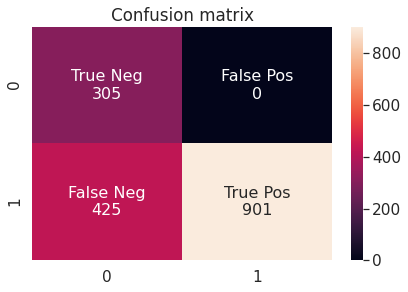

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_pred) * 100, 2), "%", sep="")

# Model F1-Score
print("F1 score: ", round(metrics.f1_score(y_test, y_pred) * 100, 2), "%", sep="")

# Recall
print("Recall: ", round(metrics.recall_score(y_test, y_pred) * 100, 2), "%", sep="")

# Precision
print("Precision: ", round(metrics.precision_score(y_test, y_pred) * 100, 2), "%", sep="")

# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# print('Confusion matrix: \n', confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_names = ['True Neg','False Pos','False Neg','True Pos']

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=labels, fmt='', annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

# Support Vector Machine (SVM)

### Using RBF Kernel

In [ ]:
#using rbf(radial-biasis-function)
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = classifier.predict(X_test)

Accuracy: 97.67%
F1 score: 98.57%
Recall: 98.72%
Precision: 98.42%


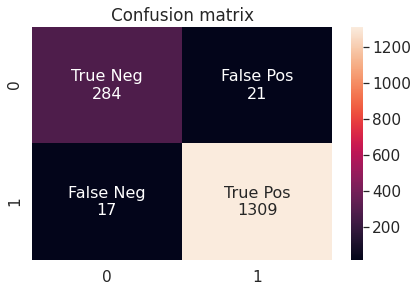

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_pred) * 100, 2), "%", sep="")

# Model F1-Score
print("F1 score: ", round(metrics.f1_score(y_test, y_pred) * 100, 2), "%", sep="")

# Recall
print("Recall: ", round(metrics.recall_score(y_test, y_pred) * 100, 2), "%", sep="")

# Precision
print("Precision: ", round(metrics.precision_score(y_test, y_pred) * 100, 2), "%", sep="")

# confusion matrix
# print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# print('Confusion matrix: \n', confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_names = ['True Neg','False Pos','False Neg','True Pos']

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=labels, fmt='', annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

### Using Polynomial Kernel

In [ ]:
#using polynomial
from sklearn.svm import SVC
classifier = SVC(kernel = 'poly', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = classifier.predict(X_test)

Accuracy: 97.67%
F1 score: 98.57%
Recall: 98.72%
Precision: 98.42%


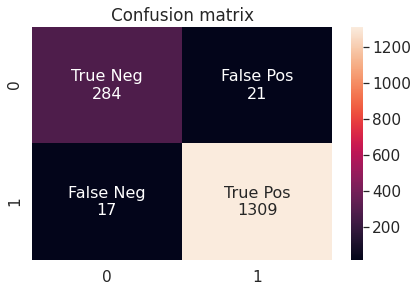

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_pred) * 100, 2), "%", sep="")

# Model F1-Score
print("F1 score: ", round(metrics.f1_score(y_test, y_pred) * 100, 2), "%", sep="")

# Recall
print("Recall: ", round(metrics.recall_score(y_test, y_pred) * 100, 2), "%", sep="")

# Precision
print("Precision: ", round(metrics.precision_score(y_test, y_pred) * 100, 2), "%", sep="")

# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# print('Confusion matrix: \n', confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_names = ['True Neg','False Pos','False Neg','True Pos']

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=labels, fmt='', annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

### Using Linear Kernel

In [ ]:
#using polynomial
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0, C=0.7)
classifier.fit(X_train, y_train)

SVC(C=0.7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = classifier.predict(X_test)

Accuracy: 96.63%
F1 score: 97.95%
Recall: 99.1%
Precision: 96.83%


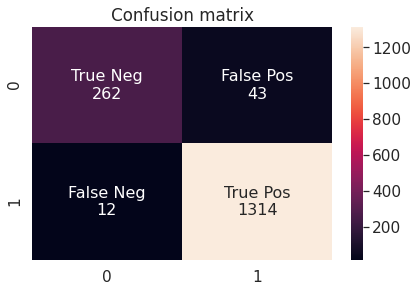

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_pred) * 100, 2), "%", sep="")

# Model F1-Score
print("F1 score: ", round(metrics.f1_score(y_test, y_pred) * 100, 2), "%", sep="")

# Recall
print("Recall: ", round(metrics.recall_score(y_test, y_pred) * 100, 2), "%", sep="")

# Precision
print("Precision: ", round(metrics.precision_score(y_test, y_pred) * 100, 2), "%", sep="")

# confusion matrix
# print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# print('Confusion matrix: \n', confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_names = ['True Neg','False Pos','False Neg','True Pos']

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=labels, fmt='', annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

# Random Forest

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.02 degrees.


Accuracy: 97.67%
F1 score: 98.57%
Recall: 98.72%
Precision: 98.42%


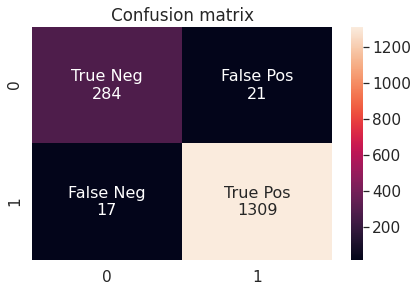

In [ ]:
y_pred = list(np.array(predictions, int))
#print(y_pred)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_pred) * 100,2), "%", sep="")

# Model F1-Score
print("F1 score: ", round(metrics.f1_score(y_test, y_pred) * 100, 2), "%", sep="")

# Recall
print("Recall: ", round(metrics.recall_score(y_test, y_pred) * 100, 2), "%" , sep="")

# Precision
print("Precision: ", round(metrics.precision_score(y_test, y_pred) * 100, 2), "%", sep= "")

# confusion matrix
# print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# print('Confusion matrix: \n', confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_names = ['True Neg','False Pos','False Neg','True Pos']

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=labels, fmt='', annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = rf.estimators_[5]# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
feature_list = list(df_data.columns)
tree = rf.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')

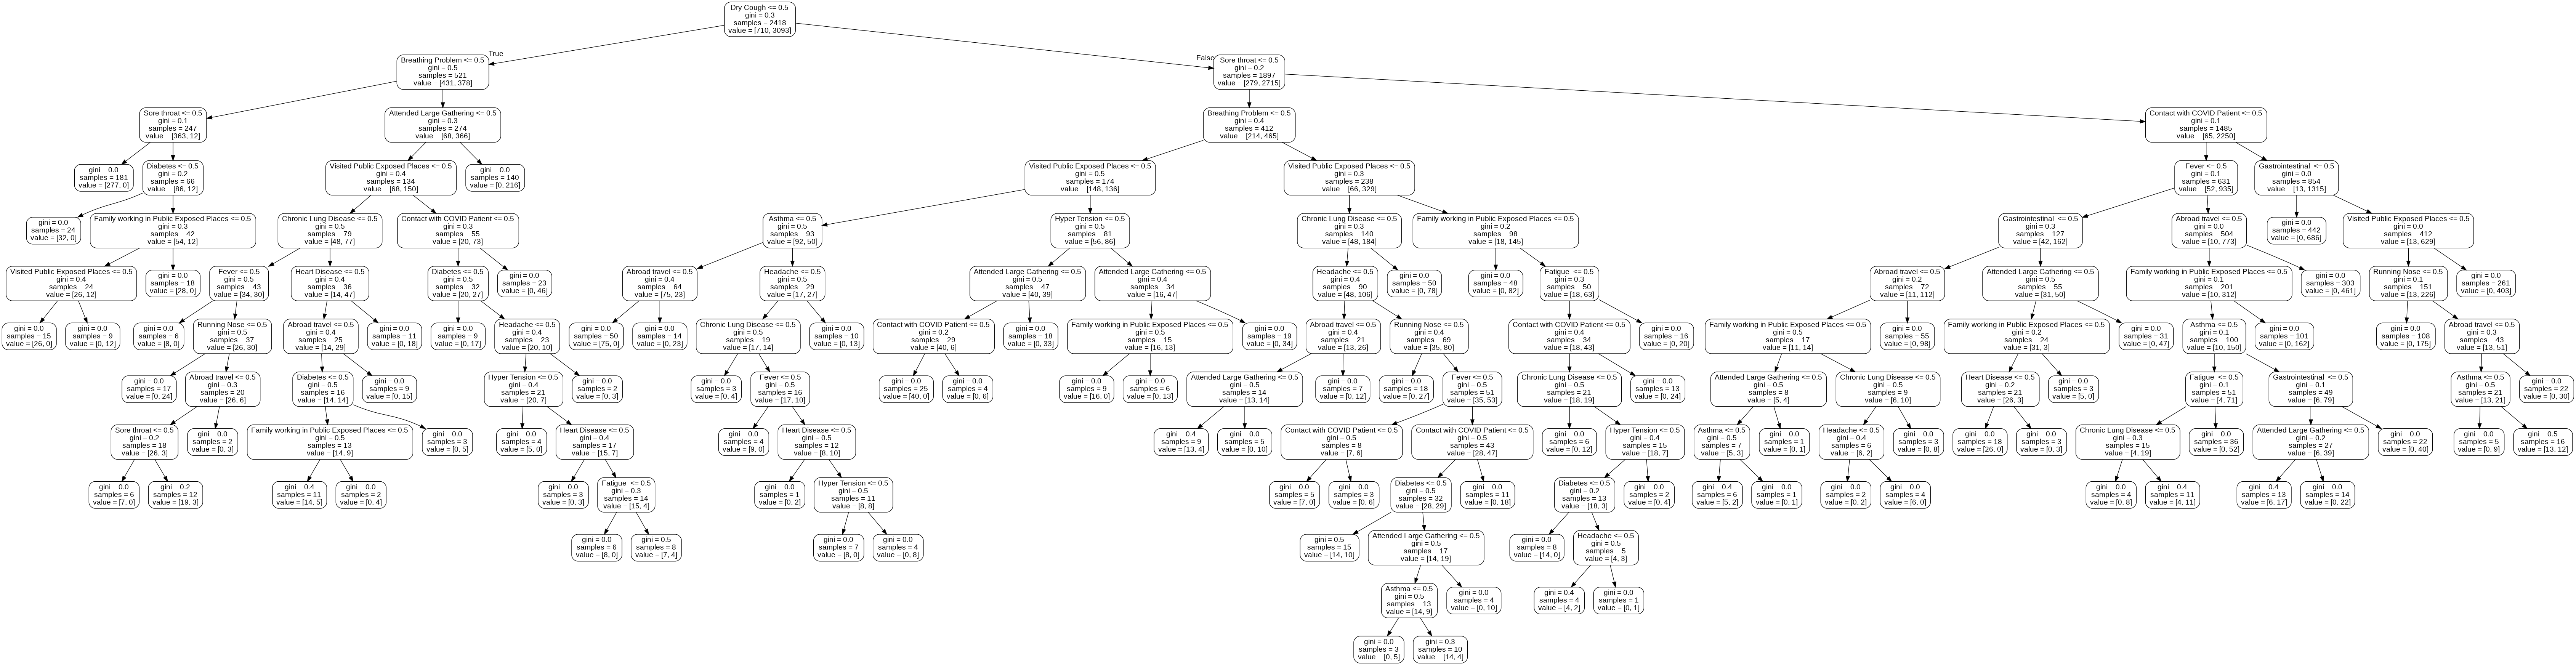

In [ ]:
from IPython.display import Image
Image('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
# Use the forest's predict method on the test data
predictions = rf_small.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.07 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
yt = np.array(y_test)
mape = 100 * (np.sum(errors) / np.sum(yt))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 91.18 %.


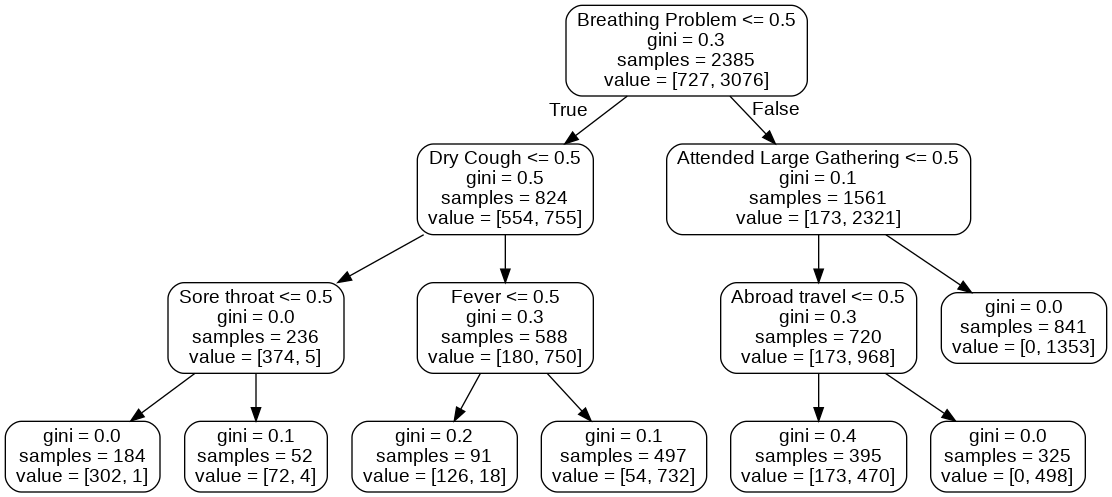

In [ ]:
from IPython.display import Image
Image('small_tree.png')

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(df, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
x_values = list(range(len(importances)))
for i in range(len(x_values)):
  print(x_values[i],"\t", feature_list[i], ":\t", importances[i])


0 	 Breathing Problem :	 0.1898411239864511
1 	 Fever :	 0.05838269593389163
2 	 Dry Cough :	 0.11275717081493523
3 	 Sore throat :	 0.14006205115792664
4 	 Running Nose :	 0.0217575474918759
5 	 Asthma :	 0.017847331518768914
6 	 Chronic Lung Disease :	 0.0197824282595928
7 	 Headache :	 0.014518223792147502
8 	 Heart Disease :	 0.024278322179457173
9 	 Diabetes :	 0.01656778054839543
10 	 Hyper Tension :	 0.01813304104102121
11 	 Fatigue  :	 0.015519733547288991
12 	 Gastrointestinal  :	 0.011582140836254315
13 	 Abroad travel :	 0.1614158655691222
14 	 Contact with COVID Patient :	 0.04958016034681725
15 	 Attended Large Gathering :	 0.08593498634495127
16 	 Visited Public Exposed Places :	 0.0205894807829551
17 	 Family working in Public Exposed Places :	 0.021449915848147316
18 	 Wearing Masks :	 0.0
19 	 Sanitization from Market :	 0.0


Text(0.5, 1.0, 'Variable Importances')

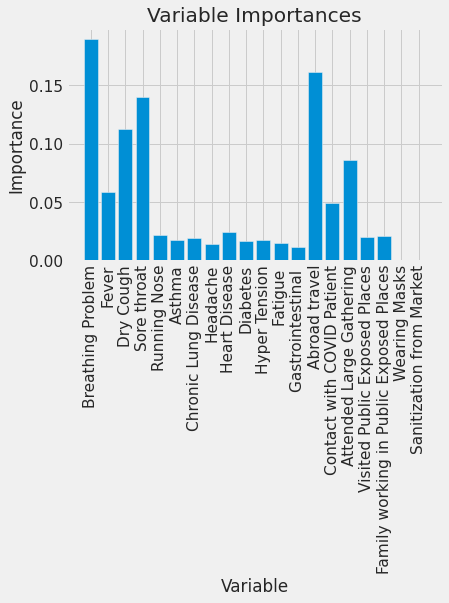

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

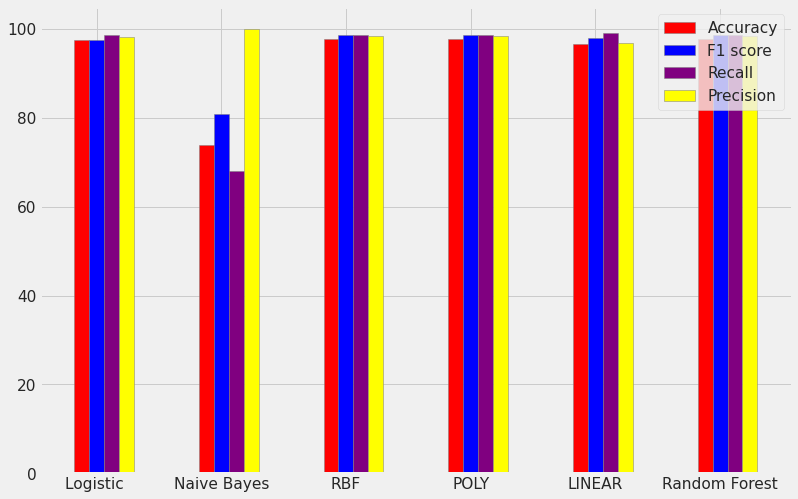

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.12
fig = plt.subplots(figsize =(12, 8))

# set height of bar
Accuracy = [97.43,73.94,97.67,97.67,96.62,97.67]
F1_score = [97.43,80.91,98.56, 98.56,97.95, 98.56]
Precision = [98.30, 100,98.42,98.42, 96.83,98.42]
Recall = [ 98.59,67.94, 98.71,98.71, 99.09,98.71]


# Set position of bar on X axis
br1 = np.arange(len(Accuracy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]


# Make the plot
plt.bar(br1, Accuracy, color ='red', width = barWidth,
		edgecolor ='grey', label ='Accuracy')
plt.bar(br2, F1_score, color ='Blue', width = barWidth,
		edgecolor ='grey', label ='F1 score')
plt.bar(br3, Recall, color ='Purple', width = barWidth,
		edgecolor ='grey', label ='Recall')
plt.bar(br4, Precision, color ='Yellow', width = barWidth,
		edgecolor ='grey', label ='Precision')


# Adding Xticks
plt.xticks([r + barWidth for r in range(len(Accuracy))],
		['Logistic ','Naive Bayes','RBF','POLY','LINEAR','Random Forest'])

plt.legend()
plt.show()